In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits
import healpy as hp
from astropy import wcs

from scipy.ndimage.filters import gaussian_filter

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
ccdnamenumdict = {'S1': 25, 'S2': 26, 'S3': 27, 'S4':28,
                  'S5': 29, 'S6': 30, 'S7': 31,
                  'S8': 19, 'S9': 20, 'S10': 21, 'S11': 22, 'S12': 23,
                  'S13': 24,
                  'S14': 13, 'S15': 14, 'S16': 15, 'S17': 16, 'S18': 17,
                  'S19': 18,
                  'S20': 8, 'S21': 9, 'S22': 10, 'S23': 11, 'S24': 12,
                  'S25': 4, 'S26': 5, 'S27': 6, 'S28': 7,
                  'S29': 1, 'S30': 2, 'S31': 3,
                  'N1': 32, 'N2': 33, 'N3': 34, 'N4': 35,
                  'N5': 36, 'N6': 37, 'N7': 38,
                  'N8': 39, 'N9': 40, 'N10': 41, 'N11': 42, 'N12': 43,
                  'N13': 44,
                  'N14': 45, 'N15': 46, 'N16': 47, 'N17': 48, 'N18': 49,
                  'N19': 50,
                  'N20': 51, 'N21': 52, 'N22': 53, 'N23': 54, 'N24': 55,
                  'N25': 56, 'N26': 57, 'N27': 58, 'N28': 59,
                  'N29': 60, 'N30': 61, 'N31': 62}
ccdnamenumdict_inv = {aa: bb for bb, aa in ccdnamenumdict.items()}

ccdnum_list = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 62]

ccd_ra = [-0.31244368,-0.00214103, 0.30855858,-0.46789986,-0.1573787 , 0.15336207,
  0.4637642 ,-0.62325889,-0.312972  ,-0.00212455, 0.30866507, 0.61908193,
 -0.77859061,-0.46870955,-0.15780883, 0.15334942, 0.46418217, 0.77441054,
 -0.77876058,-0.46892617,-0.15799484, 0.15333136, 0.46448109, 0.77444204,
 -0.93389515,-0.624237  ,-0.31362077,-0.00213867, 0.30892024, 0.61974856,
  0.92929411,-0.93410772,-0.62439031,-0.31379523,-0.00251046, 0.30860373,
  0.61929563, 0.92907893,-0.77928668,-0.46927775,-0.15819325, 0.15315534,
  0.464108  , 0.77408146,-0.7791703 ,-0.46938561,-0.15825837, 0.15269545,
  0.46382537, 0.77383443,-0.6239286 ,-0.31363566,-0.00262614, 0.30814956,
  0.61848423,-0.46862823,-0.15833137, 0.15254403, 0.46295505,-0.31333245,
  0.30765903]

ccd_dec = [ 0.90299039, 0.90274404, 0.90285652, 0.73894001, 0.73933177, 0.73919444,
  0.73865878, 0.5745655 , 0.57508801, 0.57510357, 0.57486577, 0.57414278,
  0.41001556, 0.41059824, 0.41088721, 0.41057117, 0.41032572, 0.40963196,
  0.24595122, 0.24597951, 0.24624207, 0.24619019, 0.24582139, 0.24534302,
  0.08128957, 0.08150002, 0.08130657, 0.08138846, 0.0810964 , 0.08093379,
  0.08089282,-0.08302691,-0.08319348,-0.08340522,-0.08351659,-0.08366242,
 -0.08355805,-0.08365399,-0.24756494,-0.2479717 ,-0.24812127,-0.24835309,
 -0.2482645 ,-0.2480924 ,-0.41173856,-0.41236738,-0.41281328,-0.41296242,
 -0.41270174,-0.41225407,-0.57638265,-0.57687683,-0.57711492,-0.57725814,
 -0.57674114,-0.74071528,-0.74115162,-0.74130891,-0.74095896,-0.9049206 ,
 -0.90515532]

In [6]:
band = 'z'

plot_dir = '/global/project/projectdirs/desi/www/users/rongpu/plots/dr9dev/decam_images/'

image_dir = '/global/cfs/cdirs/cosmo/staging/decam/CP/'
frgscale_dir = '/global/cscratch1/sd/rongpu/fringe/frgscale_applied_20200302/'

# surveyccd_path = '/global/homes/r/rongpu/mydesi/dr9/fringe/misc/survey-ccds-decam-dr9-z-band-only-trim.fits'
surveyccd_path = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/survey-ccds-decam-dr9.fits.gz'

# Load CCD list
ccd_columns = ['image_filename', 'image_hdu', 'expnum', 'ccdname', 'filter', 'ccd_cuts']
# ccd = fitsio.read(surveyccd_path, columns=ccd_columns)
ccd = fitsio.read(surveyccd_path, columns=ccd_columns)
ccd = Table(ccd)
mask = ccd['ccd_cuts']==0
mask &= ccd['filter']==band
ccd = ccd[mask]
print(len(ccd))
ccd['ccdnum'] = [ccdnamenumdict[ccd['ccdname'][ii].strip()] for ii in range(len(ccd))]

# DR8 survey-ccd file
ccd_columns = ['ra', 'dec', 'image_filename', 'image_hdu', 'expnum', 'ccdname', 'filter', 'ccd_cuts', 'plver']
ccd_dr8 = Table(fitsio.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/survey-ccds-decam-dr8.fits.gz', columns=ccd_columns))
mask = ccd_dr8['filter']==band
# mask &= ccd_dr8['ccd_cuts']==0
print(np.sum(mask))
ccd_dr8 = ccd_dr8[mask]

# # Select CCDs in dr9e
# # with open('/global/project/projectdirs/desi/users/rongpu/dr9/fringe/misc/dr9d_decam.txt') as f:
# with open('/global/project/projectdirs/cosmo/work/users/djschleg/dr9d/files-dr9d-south.txt') as f:
#     filelist = np.array(list(map(str.rstrip, f.readlines())))
# print(len(filelist))
# # # Select z-band images
# # mask = np.array([tt.find('_z_')!=-1 for tt in filelist])
# # filelist = filelist[mask]
# image_filename_list = np.array(list(map(str.rstrip, ccd['image_filename'])))
# mask = np.in1d(image_filename_list, filelist)
# print(np.sum(mask), np.sum(~mask))
# ccd = ccd[mask]

expnum_list = np.unique(ccd['expnum'])

# shuffle
np.random.seed(123)
# DO NOT USE NP.RANDOM.SHUFFLE
expnum_list = np.random.choice(expnum_list, size=len(expnum_list), replace=False)

1682129
2224710


expnum: 266711
expnum: 674362
expnum: 626403
/global/cfs/cdirs/cosmo/staging/decam/CP/V4.1/CP20170305/c4d_170306_035410_ooi_z_v1.fits.fz
/global/cfs/cdirs/cosmo/staging/decam/CP/V4.8.2/CP20170305/c4d_170306_035410_ooi_z_ls9.fits.fz


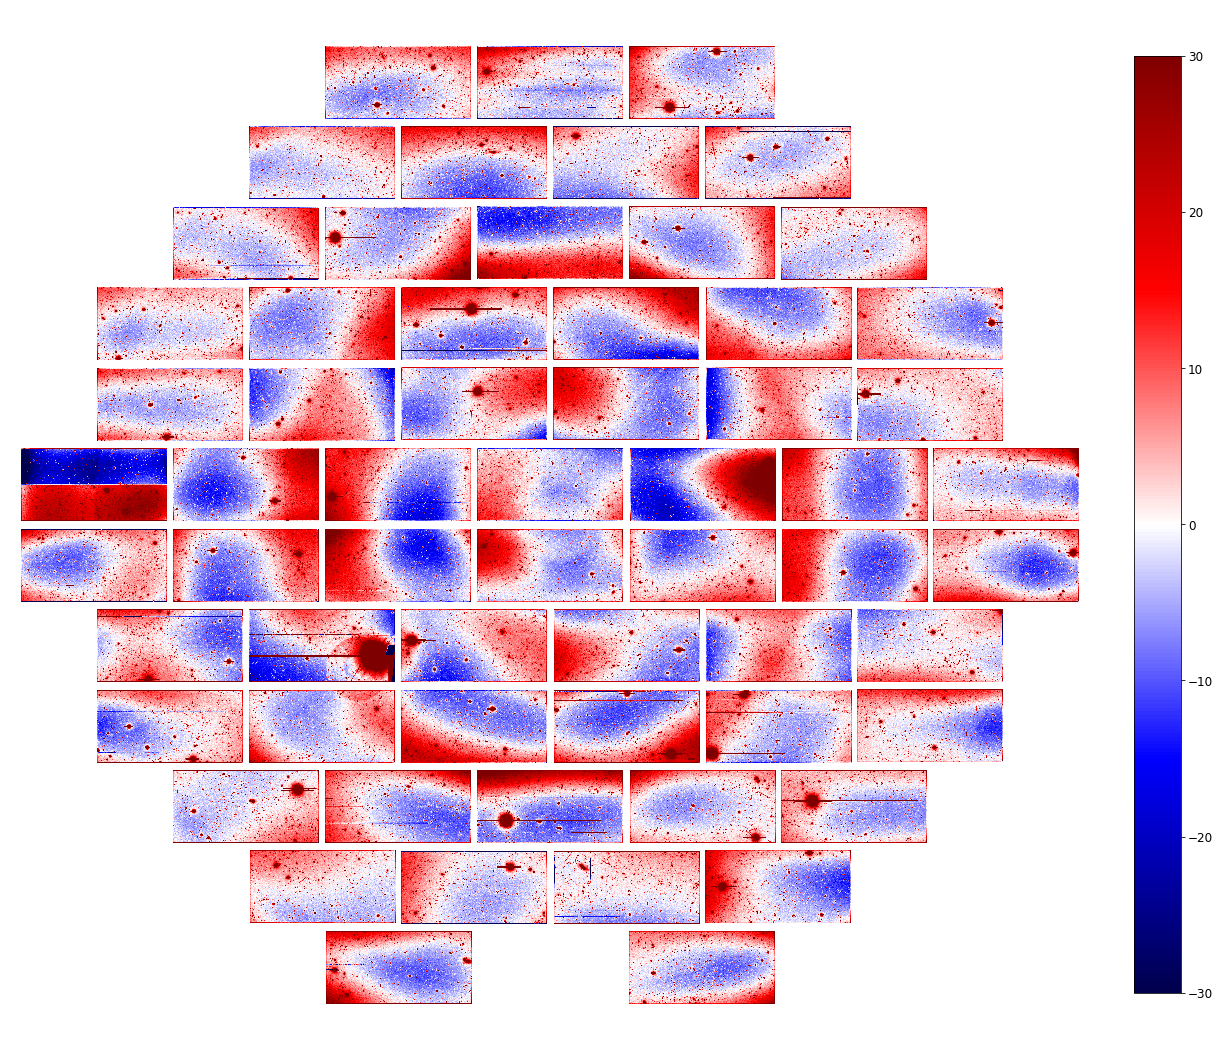

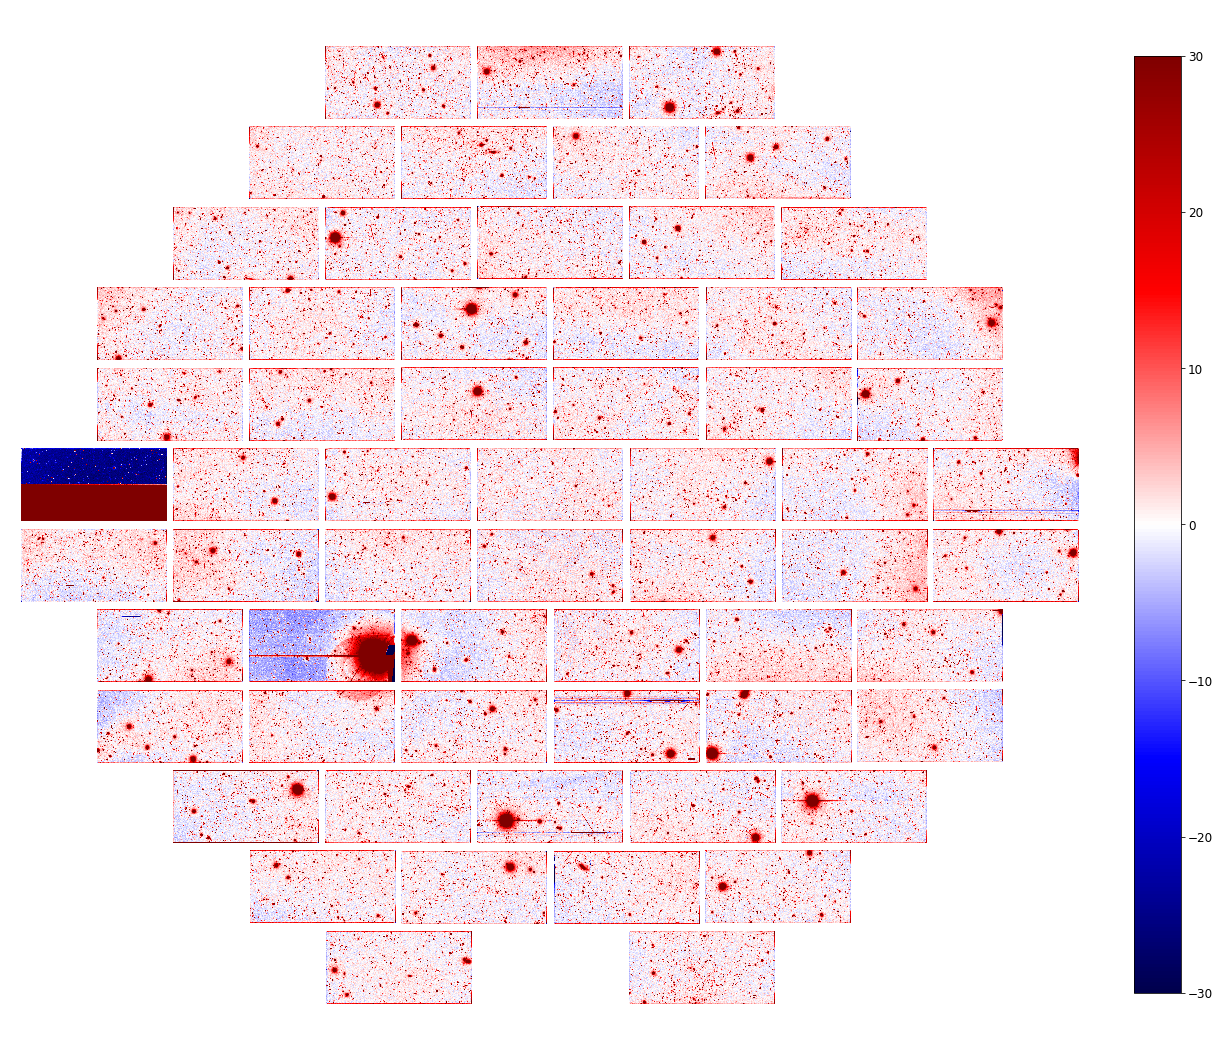

expnum: 686455
expnum: 790823
/global/cfs/cdirs/cosmo/staging/decam/CP/V4.1/CP20181104/c4d_181105_002532_ooi_z_v1.fits.fz
/global/cfs/cdirs/cosmo/staging/decam/CP/V4.8.2a/CP20181104/c4d_181105_002532_ooi_z_ls9.fits.fz
expnum: 724029
skip NonDECaLS
expnum: 506084
/global/cfs/cdirs/cosmo/staging/decam/CP/V3.9/CP20151226/c4d_151227_061651_ooi_z_v1.fits.fz
/global/cfs/cdirs/cosmo/staging/decam/CP/V4.8.2a/CP20151226/c4d_151227_061651_ooi_z_ls9.fits.fz
expnum: 584479
Not found: /global/cfs/cdirs/cosmo/staging/decam/CP/V4.1/decam/NonDECaLS/CP20161020/c4d_161021_043247_ooi_z_v2.fits.fz
decam/NonDECaLS/CP20161020/c4d_161021_043247_ooi_z_v2.fits.fz

expnum: 663685
/global/cfs/cdirs/cosmo/staging/decam/CP/V4.1/CP20170731/c4d_170801_040657_ooi_z_v1.fits.fz
/global/cfs/cdirs/cosmo/staging/decam/CP/V4.8.2/CP20170731/c4d_170801_040657_ooi_z_ls9.fits.fz
expnum: 724749
/global/cfs/cdirs/cosmo/staging/decam/CP/V4.1/CP20180223/c4d_180224_012647_ooi_z_v1.fits.fz
/global/cfs/cdirs/cosmo/staging/decam/CP/V4

In [10]:
vrange = 30
binsize = 2
pix_size = 0.262/3600*binsize

for index, expnum in enumerate(expnum_list[:20]):

    print('expnum:', expnum)

    # Find an arbitrary CCD in the exposure to get the image filename
    try:
        ccd_index = np.where((ccd_dr8['expnum']==expnum))[0][0]
    except:
        continue

    ccd_index_0 = np.where((ccd['expnum']==expnum))[0][0]

    frgscale_path = os.path.join(frgscale_dir, ccd['image_filename'][ccd_index_0].strip().replace('.fits.fz', '.txt'))
    image_path_dr9fg = os.path.join('/global/cfs/cdirs/cosmo/staging/', ccd['image_filename'][ccd_index_0].strip())
    image_path_dr8 = os.path.join(image_dir, ccd_dr8['plver'][ccd_index], ccd_dr8['image_filename'][ccd_index].strip())
    image_path_dr8 = image_path_dr8.replace('decam/DECam_CP/', '').replace('decam/DECam_Reprocessed/', '')
    if 'NonDECaLS-DR8' in ccd_dr8['image_filename'][ccd_index]:
        # image_path_dr8 = '/global/projecta/projectdirs/cosmo/staging/' + ccd_dr8['image_filename'][ccd_index].strip()
        print('skip NonDECaLS')
        continue
    
    if not os.path.isfile(image_path_dr8):
        print('Not found:', image_path_dr8)
        print(ccd_dr8['image_filename'][ccd_index])
        print()
        continue
    
    print(image_path_dr8)
    print(image_path_dr9fg)


    ############################## new fringe-corrected images ##############################
    
    plt.figure(figsize=(17, 15))

    for ii, ccdnum in enumerate(ccdnum_list):
        
        try:
            img = fits.getdata(image_path_dr9fg, extname=ccdnamenumdict_inv[ccdnum])
        except:
            continue
            
        ################ downsize image ################

        # trim edges to enable downsizing
        # trimmed image size need to be multiples of binsize
        trim_size_x = img.shape[1] % binsize
        trim_size_y = img.shape[0] % binsize
        img = img[:(img.shape[0]-trim_size_y), :(img.shape[1]-trim_size_x)]
        # print(img.shape)

        # to ignore NAN values, use np.nanmean
        img = np.mean(np.mean(img.reshape((img.shape[0]//binsize, binsize, img.shape[1]//binsize,-1)), axis=3), axis=1)

        ################################################

        ysize, xsize = img.shape        
        ra, dec = ccd_ra[ii], ccd_dec[ii]

        # naive sky estimation
        mask = (img<np.percentile(img.flatten(), 95))
        median_sky = np.median(img[mask].flatten())
        
        img = img - median_sky
        img[~np.isfinite(img)] = 0
        img = gaussian_filter(img, 3, mode='reflect', truncate=3)
        fig = plt.imshow(img.T, cmap='seismic', vmin=-vrange, vmax=vrange, 
                   extent=(ra-ysize*pix_size/2, ra+ysize*pix_size/2, dec-xsize*pix_size/2, dec+xsize*pix_size/2))

    plt.axis([1.1, -1.1, -1.05, 1.05])
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.colorbar(fraction=0.04, pad=0.04)
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, os.path.basename(image_path_dr9fg).replace('.fits.fz', '.png')))
    if index==2:
        plt.show()
    plt.close()

    ############################## DR8 images ##############################
    
    plt.figure(figsize=(17, 15))

    for ii, ccdnum in enumerate(ccdnum_list):
        
        try:
            img = fits.getdata(image_path_dr8, extname=ccdnamenumdict_inv[ccdnum])
        except:
            continue

        ################ downsize image ################

        # trim edges to enable downsizing
        # trimmed image size need to be multiples of binsize
        trim_size_x = img.shape[1] % binsize
        trim_size_y = img.shape[0] % binsize
        img = img[:(img.shape[0]-trim_size_y), :(img.shape[1]-trim_size_x)]
        # print(img.shape)

        # to ignore NAN values, use np.nanmean
        img = np.mean(np.mean(img.reshape((img.shape[0]//binsize, binsize, img.shape[1]//binsize,-1)), axis=3), axis=1)

        ################################################

        ysize, xsize = img.shape        
        ra, dec = ccd_ra[ii], ccd_dec[ii]

        # naive sky estimation
        mask = (img<np.percentile(img.flatten(), 95))
        median_sky = np.median(img[mask].flatten())
        
        img = img - median_sky
        img[~np.isfinite(img)] = 0
        img = gaussian_filter(img, 3, mode='reflect', truncate=3)
        fig = plt.imshow(img.T, cmap='seismic', vmin=-vrange, vmax=vrange, 
                   extent=(ra-ysize*pix_size/2, ra+ysize*pix_size/2, dec-xsize*pix_size/2, dec+xsize*pix_size/2))

    plt.axis([1.1, -1.1, -1.05, 1.05])
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.colorbar(fraction=0.04, pad=0.04)
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, os.path.basename(image_path_dr8).replace('.fits.fz', '.png')))
    if index==2:
        plt.show()
    plt.close()